In [1]:
import keras
import tensorflow as tf

print(tf.__version__)
print(keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-03-28 12:54:28.445391: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 12:54:28.482916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 12:54:28.482956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 12:54:28.484414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 12:54:28.491529: I tensorflow/core/platform/cpu_feature_guar

2.15.1
2.15.0
Num GPUs Available:  1


2024-03-28 12:54:29.800806: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 12:54:29.831588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 12:54:29.831794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
import numpy as np
from skimage import io
from keras import backend as K
import segmentation_models_3D as sm
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split

Segmentation Models: using `tf.keras` framework.


In [3]:
#Load input images and masks. 
image = io.imread('./data/Fluo-N3DH-SIM+/01/t027.tif')
mask = io.imread('./data/Fluo-N3DH-SIM+/01_GT/SEG/man_seg027.tif')
mask.shape, np.unique(mask)

((59, 349, 639), array([ 0,  3,  7, 10, 11, 12, 15, 16, 17, 18], dtype=uint16))

In [4]:
(mask > 0).sum() / np.prod(mask.shape), (mask == 0).sum() / np.prod(mask.shape)

(0.02361417301829529, 0.9763858269817047)

In [5]:
# #Load multiple images
# images = []
# masks = []

# for i in range(1, 10):
#     image = io.imread(f'./data/Fluo-N3DH-SIM+/01/t{i:03d}.tif')
#     image = patchify(image, (32, 32, 32), step=32)
#     mask = io.imread(f'./data/Fluo-N3DH-SIM+/01_GT/SEG/man_seg{i:03d}.tif')
#     mask = patchify(mask, (32, 32, 32), step=32)  

#     images.append(image)
#     masks.append(mask)

# img_patches = np.array(images)
# mask_patches = np.array(masks)
# img_patches.shape, mask_patches.shape

In [6]:
img_patches = patchify(image, (32, 32, 32), step=32)
mask_patches = patchify(mask, (32, 32, 32), step=32)  

In [7]:
img_patches.shape, mask_patches.shape

((1, 10, 19, 32, 32, 32), (1, 10, 19, 32, 32, 32))

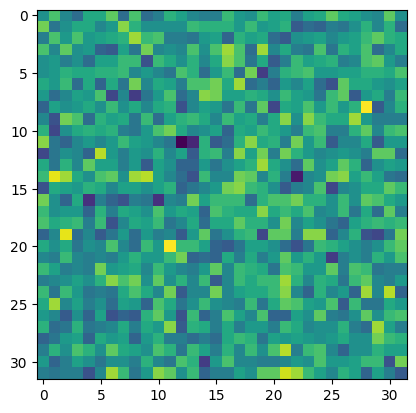

In [8]:
plt.imshow(img_patches[0,2,3,0,:,:])

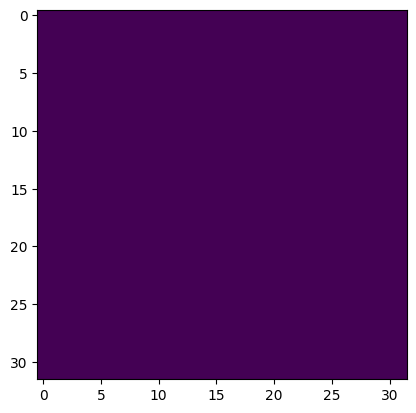

In [9]:
plt.imshow(mask_patches[0,2,3,0,:,:])

In [10]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)  # n_patches, x, y, z

(190, 32, 32, 32)


In [11]:
n_classes=2

In [12]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 
train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)
train_img.shape, train_mask.shape

((190, 32, 32, 32, 3), (190, 32, 32, 32, 1))

In [13]:
np.unique(train_mask)

array([ 0,  3, 10, 11, 12, 15, 17], dtype=uint16)

In [14]:
train_mask_cat = (train_mask > 0).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)

In [15]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [16]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 32
n_classes = 2
channels = 3
epochs = 1000

LR = 1e-5
optim = keras.optimizers.AdamW(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
cell_w = (mask > 0).sum() / np.prod(mask.shape)
bg_w = (mask == 0).sum() / np.prod(mask.shape)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([bg_w, cell_w,])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

2024-03-28 12:54:35.380519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 12:54:35.380707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 12:54:35.380779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
#Preprocess input data - otherwise you end up with garbage resutls 
# and potentially model that does not converge.
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [19]:
X_train_prep.dtype, y_train.dtype

(dtype('uint16'), dtype('float32'))

In [20]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 32, 32, 32, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 32, 32, 32, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding3d (ZeroPaddin  (None, 38, 38, 38, 3)        0         ['bn_data[0][0]']             
 g3D)                                                                                             
                                                                                            

In [21]:
#Fit the model
history=model.fit(X_train_prep, 
          y_train,
          batch_size=16, 
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_prep, y_test))

Epoch 1/1000


2024-03-28 12:54:48.328617: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:403] Cancel Transpose nodes around Pad: transpose_before=model_1/bn_data/FusedBatchNormV3-0-1-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_1/zero_padding3d/Pad transpose_after=model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/model_1/conv0/Conv3D/Conv3DBackpropFilterV2-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/model_1/conv0/Conv3D/ShapeN-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2024-03-28 12:54:50.150184: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-28 12:54:50.157113: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-28 12:54:50.242151: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-28 12:54:57.130365: I external/local_xla/xla/service/service.cc

11/11 [==============================] - 52s 2s/step - loss: 0.9970 - iou_score: 0.0034 - f1-score: 0.0068 - val_loss: 0.9924 - val_iou_score: 0.0048 - val_f1-score: 0.0096
Epoch 2/1000
11/11 [==============================] - 2s 157ms/step - loss: 0.9960 - iou_score: 0.0039 - f1-score: 0.0076 - val_loss: 0.9925 - val_iou_score: 0.0050 - val_f1-score: 0.0100
Epoch 3/1000
11/11 [==============================] - 2s 156ms/step - loss: 0.9951 - iou_score: 0.0046 - f1-score: 0.0090 - val_loss: 0.9921 - val_iou_score: 0.0053 - val_f1-score: 0.0105
Epoch 4/1000
11/11 [==============================] - 2s 156ms/step - loss: 0.9947 - iou_score: 0.0050 - f1-score: 0.0099 - val_loss: 0.9918 - val_iou_score: 0.0059 - val_f1-score: 0.0117
Epoch 5/1000
11/11 [==============================] - 2s 156ms/step - loss: 0.9944 - iou_score: 0.0053 - f1-score: 0.0104 - val_loss: 0.9919 - val_iou_score: 0.0053 - val_f1-score: 0.0104
Epoch 6/1000
11/11 [==============================] - 2s 156ms/step - loss:

In [22]:
#Save model for future use
model.save(f'3D_model_{BACKBONE}_ep{epochs}.h5')

/home/asebaq/dev/cell_segmentation/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


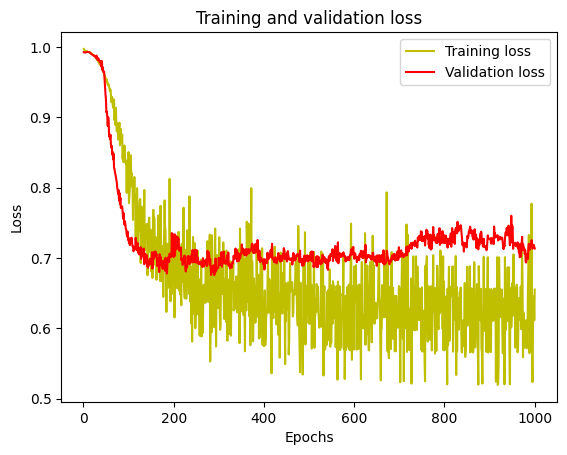

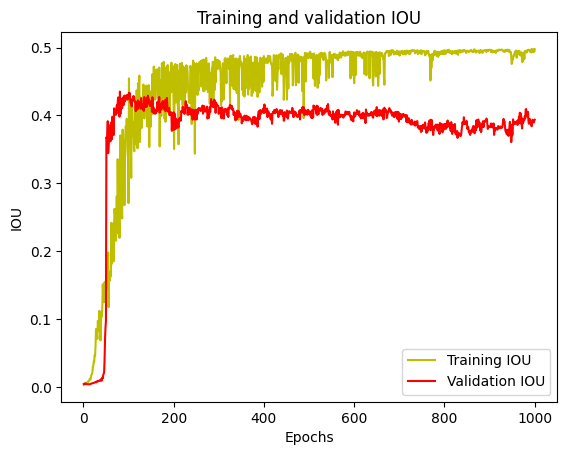

In [23]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [24]:
#Load the pretrained model for testing and predictions. 
from keras.models import load_model
my_model = load_model('3D_model_vgg16_200epochs.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly. 

In [25]:
#Predict on the test data
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


1/1 [==============================] - 8s 8s/step


In [26]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(19, 32, 32, 32)
(19, 32, 32, 32)
[0 1]


In [27]:
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.12467716


In [28]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)

1/1 [==============================] - 2s 2s/step
(32, 32, 32)


In [29]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

(32, 32, 32, 3)


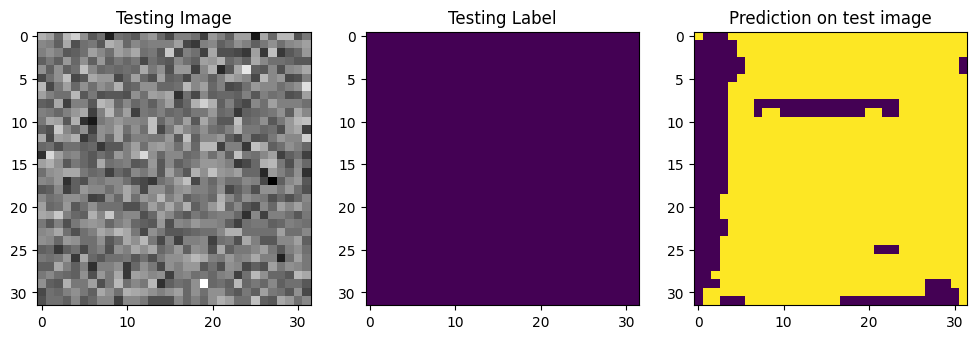

In [30]:
#Plot individual slices from test predictions for verification
slice = 14
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

Now segment the full volume using the trained model.

In [31]:
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = io.imread('data/Fluo-N3DH-SIM+/02/t000.tif')
patches = patchify(large_image, (32, 32, 32), step=32)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(59, 642, 652)
(1, 20, 20, 32, 32, 32)


In [32]:
# Predict each 3D patch   
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)
      


1/1 [==============================] - 0s 19ms/step


In [ ]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

In [ ]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

In [ ]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

In [ ]:
print(reconstructed_image.dtype)

In [ ]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

In [ ]:
#Now save it as segmented volume.
from tifffile import imsave
imsave('/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented.tif', reconstructed_image)
    

In [ ]:
#If you would like to save the volume as multichannel dataset....

In [ ]:
print(np.unique(reconstructed_image))

In [ ]:
#Seperate each channel/segment to be combined as multiple channels.
num_segments=4
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)
segm3 = (reconstructed_image == 3)

final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
final[:,:,:,0] = segm0
final[:,:,:,1] = segm1
final[:,:,:,2] = segm2
final[:,:,:,3] = segm3

In [ ]:
#Use APEER OMETIFF library to read and write multidimensional images
!pip install apeer-ometiff-library

In [ ]:
from apeer_ometiff_library import io

In [ ]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)



In [ ]:
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)


In [ ]:
# Write dataset as multi-dimensional OMETIFF *image*
io.write_ometiff("segmented_multi_channel.ome.tiff", final)